# Functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
print(pd.__version__)
print(np.__version__)
print(matplotlib.__version__)

1.4.4
1.24.4
3.5.2


In [2]:
# Teoria
###################################################################################################################
def plot_curva_demanda_elasticidade_exemplo():
    # define a curva de demanda P = 4 - 2Q
    Q = np.linspace(0, 2, 200)
    P = 4 - 2 * Q
    # define o ponto de elasticidade unitária (ε = -1)
    Q_star = 1.0
    P_star = 4 - 2 * Q_star
    # cria a figura e o eixo
    fig, ax = plt.subplots(figsize=(8, 6))
    # plota a curva de demanda
    ax.plot(Q, P)
    # marca o ponto de elasticidade unitária
    ax.scatter([Q_star], [P_star], zorder=3)
    # desenha linhas tracejadas até os eixos
    ax.axvline(Q_star, ymax=P_star / P.max(), linestyle="--")
    ax.axhline(P_star, xmax=Q_star / Q.max(), linestyle="--")
    # anota o ponto crítico com leve deslocamento
    ax.text(Q_star + 0.04, P_star - 0.25, "(1, 2)", fontsize=10)
    # anotações das regiões de elasticidade
    ax.text(0.15, 3.2, "ε ∈ (-∞, -1)\nelástica", ha="left", va="center")
    ax.text(0.15, 2.15, "ε = -1\nelasticidade unitária", ha="left", va="center")
    ax.text(0.15, 1.05, "ε ∈ (-1, 0)\ninelástica", ha="left", va="center")
    # títulos e rótulos em português
    ax.set_title("Exemplo de curva de demanda P = 4 − 2Q\ncom elasticidade-preço da quantidade ε = 1 − 2/Q")
    ax.set_xlabel("Quantidade Q")
    ax.set_ylabel("Preço P")
    # ajusta limites do gráfico
    ax.set_xlim(0, 2.05)
    ax.set_ylim(0, 4.1)
    # fecha a figura para controle externo
    #plt.close(fig)
    # retorna a figura para exibição ou salvamento
    #return fig


###################################################################################################################
# gera a base transacional inicial apenas com ID, anomes e preço pago
def gerar_df_preco(n=200_000, x_min=0.0, x_max=1.0, A=80.0, B=-30.0, seed=42, anomes=202501):
    # fixa a semente aleatória para garantir reprodutibilidade
    np.random.seed(seed)
    # gera uma população potencial maior do que a observada
    x = np.random.uniform(x_min, x_max, n)
    # define o preço pago como função linear decrescente da captação latente
    valor_pago = A + B * x
    # adiciona ruído leve ao preço para evitar alinhamento perfeito
    valor_pago = valor_pago + np.random.normal(0, 0.5, n)
    # define uma probabilidade de compra decrescente no preço (quick and dirty)
    prob_compra = 1 - (valor_pago - valor_pago.min()) / (valor_pago.max() - valor_pago.min())
    # garante que a probabilidade esteja no intervalo [0, 1]
    prob_compra = np.clip(prob_compra, 0.01, 0.99)
    # sorteia quais indivíduos efetivamente compram
    compra = np.random.binomial(1, prob_compra)
    # filtra apenas os indivíduos que realizaram compra
    valor_pago = valor_pago[compra == 1]
    # constrói a base transacional inicial apenas com compradores
    df = pd.DataFrame({"ID": np.arange(1, len(valor_pago) + 1), "Anomes": anomes, "ValorPago": valor_pago})
    # retorna o DataFrame inicial pronto para enriquecimento
    return df

# Funções da esteira analítica
###################################################################################################################
# acrescenta elasticidade individual e valor futuro à base transacional existente
def adicionar_elasticidade_e_valor_futuro(df, a=1.2, b=0.015, c=0.00012, noise_std=0.05, seed=42):
    # fixa a semente aleatória para garantir reprodutibilidade
    np.random.seed(seed)
    # extrai o preço pago como array numpy
    valor_pago = df["ValorPago"].values
    # define a elasticidade individual como função quadrática do preço com ruído leve
    elasticidade = a + b * valor_pago - c * valor_pago**2 + np.random.normal(0, noise_std, len(valor_pago))
    # impõe piso mínimo para evitar elasticidades negativas
    elasticidade = np.clip(elasticidade, 0.01, None)
    # calcula o valor futuro como produto direto entre elasticidade e preço pago
    valor_futuro = elasticidade * valor_pago
    # cria uma cópia do DataFrame para evitar efeitos colaterais
    df = df.copy()
    # adiciona a coluna de valor futuro
    df["ValorFuturo"] = valor_futuro
    # adiciona a elasticidade observada como razão entre valor futuro e valor pago
    df["Elasticidade"] = df["ValorFuturo"] / df["ValorPago"]
    # retorna o DataFrame final enriquecido
    return df

#
def agregar_por_elasticidade(df, n_bins=20):
    # cria limites dos buckets como faixas uniformes no intervalo observado da elasticidade
    bins = np.linspace(df["Elasticidade"].min(), df["Elasticidade"].max(), n_bins + 1)
    # cria uma cópia do DataFrame para evitar efeitos colaterais
    df = df.copy()
    # atribui cada observação a um bucket de elasticidade baseado em range contínuo
    df["bin_elasticidade"] = pd.cut(df["Elasticidade"], bins=bins, include_lowest=True)
    # obtém a ordem numérica dos bins (0, 1, 2, ...) para nomeação estável
    df["_bin_idx"] = df["bin_elasticidade"].cat.codes
    # cria um nome ordenável alfabeticamente para cada bucket (bin_01, bin_02, ...)
    df["bucket_nome"] = df["_bin_idx"].apply(lambda x: f"bin_{x+1:02d}")
    # agrega os dados por bucket calculando elasticidade mediana, mediana do preço pago e captação
    agg = df.groupby("bin_elasticidade", as_index=False
                    ).agg(Elasticidade_media=("Elasticidade", "median"), 
                          ValorPago_media=("ValorPago", "median"), 
                          Captacao=("ID", "nunique"))
    # recria o índice numérico do bin na tabela agregada para manter consistência de nomes
    agg["_bin_idx"] = agg["bin_elasticidade"].cat.codes
    # atribui o nome ordenável do bucket também na tabela agregada
    agg["bucket_nome"] = agg["_bin_idx"].apply(lambda x: f"bin_{x+1:02d}")
    # remove a coluna auxiliar de índice do bin
    agg = agg.drop(columns="_bin_idx")
    # retorna a tabela agregada pronta para análise e plotagem da curva tipo Laffer
    return agg


#
def plot_laffer_scatter(agg):
    # extrai a elasticidade média de cada bucket para o eixo x
    x = agg["Elasticidade_media"].values
    # extrai a captação (quantidade de pagantes) de cada bucket para o eixo y
    y = agg["Captacao"].values
    # cria explicitamente a figura e o eixo para controle do objeto retornado
    fig, ax = plt.subplots(figsize=(8, 5))
    # plota o scatter de captação versus elasticidade no eixo criado
    ax.scatter(x, y)
    # define o rótulo do eixo x como elasticidade média observada
    ax.set_xlabel("Elasticidade média (ValorFuturo / ValorPago)")
    # define o rótulo do eixo y como captação (contagem de pagantes)
    ax.set_ylabel("Captação (quantidade de pagantes)")
    # define o título descrevendo explicitamente o objeto da curva
    ax.set_title("Curva tipo Laffer: Captação vs Elasticidade")
    # fecha a figura para evitar renderização automática fora do controle da função
    plt.close(fig)
    # retorna o objeto figura para uso posterior (exibição, salvamento ou composição)
    return fig

#
def plot_laffer_quadratico(agg):
    # extrai a elasticidade média de cada bucket para o eixo x
    x = agg["Elasticidade_media"].values
    # extrai a captação (quantidade de pagantes) de cada bucket para o eixo y
    y = agg["Captacao"].values
    # ajusta uma parábola de grau 2 (aproximação quick and dirty da curva de Laffer)
    coef = np.polyfit(x, y, 2)
    # constrói o polinômio correspondente aos coeficientes ajustados
    poly = np.poly1d(coef)
    # cria uma grade contínua de elasticidade para desenhar a curva ajustada
    x_fit = np.linspace(x.min(), x.max(), 200)
    # avalia o polinômio ajustado sobre a grade contínua
    y_fit = poly(x_fit)
    # cria explicitamente a figura e o eixo para controle do objeto retornado
    fig, ax = plt.subplots(figsize=(8, 5))
    # plota o scatter original de captação versus elasticidade
    ax.scatter(x, y)
    # plota a curva quadrática ajustada sobre os pontos observados
    ax.plot(x_fit, y_fit)
    # define o rótulo do eixo x como elasticidade média
    ax.set_xlabel("Elasticidade média")
    # define o rótulo do eixo y como captação (quantidade de pagantes)
    ax.set_ylabel("Captação")
    # define o título indicando explicitamente o tipo de aproximação usada
    ax.set_title("Aproximação quadrática da curva de captação")
    # fecha a figura para evitar renderização automática fora da função
    plt.close(fig)
    # retorna a figura e os coeficientes da parábola (a, b, c)
    return fig, coef

# plota a curva tipo Laffer com ajuste quadrático e calcula o R² do fit
def plot_laffer_quadratico(agg):
    # extrai a elasticidade média de cada bucket para o eixo x
    x = agg["Elasticidade_media"].values
    # extrai a captação (quantidade de pagantes) de cada bucket para o eixo y
    y = agg["Captacao"].values
    # ajusta uma parábola de grau 2 (aproximação quick and dirty da curva de Laffer)
    coef = np.polyfit(x, y, 2)
    # constrói o polinômio correspondente aos coeficientes ajustados
    poly = np.poly1d(coef)
    # calcula os valores ajustados exatamente nos pontos observados
    y_hat = poly(x)
    # calcula o coeficiente de determinação R² do ajuste
    r2 = 1 - np.sum((y - y_hat) ** 2) / np.sum((y - y.mean()) ** 2)
    # cria uma grade contínua de elasticidade para desenhar a curva ajustada
    x_fit = np.linspace(x.min(), x.max(), 200)
    # avalia o polinômio ajustado sobre a grade contínua
    y_fit = poly(x_fit)
    # cria explicitamente a figura e o eixo para controle do objeto retornado
    fig, ax = plt.subplots(figsize=(8, 5))
    # plota o scatter original de captação versus elasticidade
    ax.scatter(x, y)
    # plota a curva quadrática ajustada sobre os pontos observados
    ax.plot(x_fit, y_fit)
    # define o rótulo do eixo x como elasticidade média
    ax.set_xlabel("Elasticidade média")
    # define o rótulo do eixo y como captação (quantidade de pagantes)
    ax.set_ylabel("Captação")
    # define o título indicando explicitamente o tipo de aproximação usada e o R²
    ax.set_title(f"Aproximação quadrática da curva de captação (R² = {r2:.3f})")
    # fecha a figura para evitar renderização automática fora da função
    plt.close(fig)
    # retorna a figura, os coeficientes da parábola e o R² do ajuste
    return fig, coef, r2

# agrega por preço com bins definidos por step fixo (range pré-definido), evitando bin de borda minúsculo
def agregar_por_preco_step(df, p_min=50.0, p_max=80.0, step=1.5):
    # cria os limites dos bins por passo fixo, com suporte controlado
    bins = np.arange(p_min, p_max + step, step)
    # cria uma cópia do DataFrame para evitar efeitos colaterais
    df = df.copy()
    # filtra o intervalo de preço para não poluir o primeiro/último bin com outliers de ruído
    df = df[(df["ValorPago"] >= p_min) & (df["ValorPago"] <= p_max)]
    # atribui cada observação a um bucket de preço baseado em ranges fixos
    df["bin_preco"] = pd.cut(df["ValorPago"], bins=bins, include_lowest=True)
    # obtém a ordem numérica dos bins para nomeação estável
    df["_bin_idx"] = df["bin_preco"].cat.codes
    # cria um nome ordenável alfabeticamente para cada bucket (bin_01, bin_02, ...)
    df["bucket_nome"] = df["_bin_idx"].apply(lambda x: f"bin_{x+1:02d}")
    # agrega os dados por bucket calculando preço mediano e captação
    agg_preco = df.groupby("bin_preco", as_index=False
                          ).agg(ValorPago_mediana=("ValorPago", "median"), 
                                Captacao=("ID", "nunique"))
    # recria o índice numérico do bin na tabela agregada para manter consistência de nomes
    agg_preco["_bin_idx"] = agg_preco["bin_preco"].cat.codes
    # atribui o nome ordenável do bucket também na tabela agregada
    agg_preco["bucket_nome"] = agg_preco["_bin_idx"].apply(lambda x: f"bin_{x+1:02d}")
    # remove a coluna auxiliar de índice do bin
    agg_preco = agg_preco.drop(columns="_bin_idx")
    # retorna a tabela agregada por preço pronta para regressão e plot
    return agg_preco


# plota a relação Captação (x) versus Preço mediano (y) a partir do agregado por preço
def plot_preco_vs_captacao(agg_preco):
    # extrai a captação por bucket para o eixo x
    x = agg_preco["Captacao"].values
    # extrai o preço mediano por bucket para o eixo y
    y = agg_preco["ValorPago_mediana"].values
    # cria explicitamente a figura e o eixo
    fig, ax = plt.subplots(figsize=(8, 5))
    # plota o scatter captação versus preço
    ax.scatter(x, y)
    # define rótulos e título
    ax.set_xlabel("Captação (quantidade)")
    ax.set_ylabel("Preço pago mediano")
    ax.set_title("Captação vs Preço pago (bins por step fixo)")
    # fecha a figura para controle externo
    plt.close(fig)
    # retorna a figura
    return fig


# ajusta uma regressão linear P = A + B x entre Captação (x) e Preço médio (y)
def regressao_linear_preco_captacao(agg_preco):
    # extrai a variável explicativa como captação observada
    x = agg_preco["Captacao"].values
    # extrai a variável resposta como preço pago mediano
    y = agg_preco["ValorPago_mediana"].values
    # constrói a matriz de desenho com termo constante
    X = np.column_stack([np.ones(len(x)), x])
    # estima os coeficientes via mínimos quadrados ordinários
    coef = np.linalg.lstsq(X, y, rcond=None)[0]
    # separa intercepto e inclinação da reta
    A, B = coef
    # calcula os valores ajustados pela regressão
    y_hat = X @ coef
    # calcula o coeficiente de determinação R²
    r2 = 1 - np.sum((y - y_hat)**2) / np.sum((y - y.mean())**2)
    # cria explicitamente a figura e o eixo para visualização controlada
    fig, ax = plt.subplots(figsize=(8, 5))
    # plota os pontos observados de captação versus preço
    ax.scatter(x, y)
    # plota a reta ajustada da regressão linear
    ax.plot(x, y_hat)
    # define o rótulo do eixo x como captação (demanda)
    ax.set_xlabel("Captação (demanda)")
    # define o rótulo do eixo y como preço pago mediano
    ax.set_ylabel("Preço pago mediano")
    # define o título explicitando a forma funcional estimada
    ax.set_title("Regressão linear: Preço = A + B · Captação")
    # fecha a figura para evitar renderização automática fora da função
    plt.close(fig)
    # retorna a figura, os coeficientes da reta e o R²
    return fig, A, B, r2

# Introdução

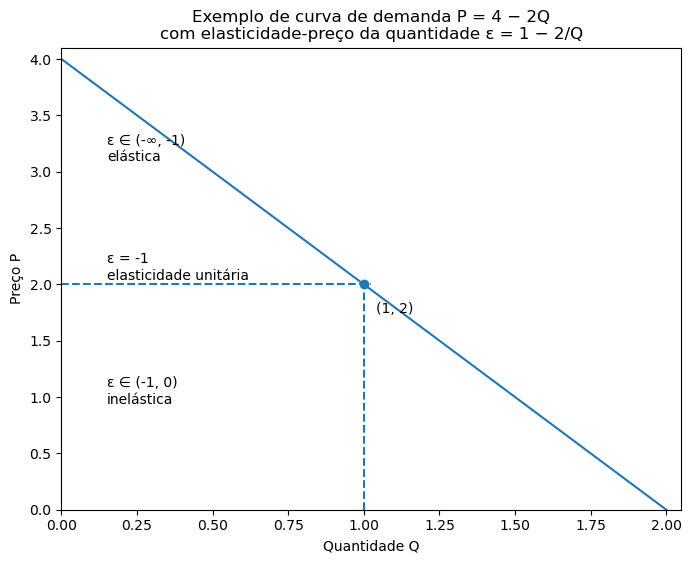

In [3]:
plot_curva_demanda_elasticidade_exemplo()

# Gera o dataset sintético

In [4]:
df_preco = gerar_df_preco(n=200_000, x_min=0.0, x_max=1.0, A=80.0, B=-30.0, seed=42, anomes=202501)

In [15]:
df_preco

,ID,Anomes,ValorPago
0,1,202501,68.595217
1,2,202501,50.591638
2,3,202501,57.979571
3,4,202501,74.991917
4,5,202501,53.986072
...,...,...,...
100423,100424,202501,51.798355
100424,100425,202501,63.820313
100425,100426,202501,52.133786
100426,100427,202501,55.371953


In [8]:
df_preco.describe()

,ID,Anomes,ValorPago
count,100428.000000,100428.0,100428.000000
mean,50214.500000,202501.0,60.488364
std,28991.210754,0.0,7.409007
min,1.000000,202501.0,48.461074
25%,25107.750000,202501.0,54.230651
50%,50214.500000,202501.0,59.243589
75%,75321.250000,202501.0,65.726136
max,100428.000000,202501.0,80.767523


# Esteira analítica

## Cria a curva de elasticidade teórica

In [9]:
df = adicionar_elasticidade_e_valor_futuro(df_preco, a=1.2, b=0.015, c=0.00012, noise_std=0.05, seed=42)

In [10]:
df

,ID,Anomes,ValorPago,ValorFuturo,Elasticidade
0,1,202501,68.595217,115.866069,1.689128
1,2,202501,50.591638,83.214122,1.644820
2,3,202501,57.979571,98.488871,1.698682
3,4,202501,74.991917,129.449227,1.726176
4,5,202501,53.986072,88.987613,1.648344
...,...,...,...,...,...
100423,100424,202501,51.798355,82.170718,1.586358
100424,100425,202501,63.820313,108.337641,1.697542
100425,100426,202501,52.133786,89.357803,1.714009
100426,100427,202501,55.371953,92.732935,1.674728


## Agrega por faixa de preço (binning)

In [11]:
#
agg_preco = agregar_por_preco_step(df, p_min=50.0, p_max=80.0, step=1.5)

In [12]:
agg_preco

,bin_preco,ValorPago_mediana,Captacao,bucket_nome
0,"(49.999, 51.5]",50.834405,7996,bin_01
1,"(51.5, 53.0]",52.249834,8852,bin_02
2,"(53.0, 54.5]",53.752329,8470,bin_03
3,"(54.5, 56.0]",55.249986,7997,bin_04
4,"(56.0, 57.5]",56.747845,7371,bin_05
5,"(57.5, 59.0]",58.226761,7154,bin_06
6,"(59.0, 60.5]",59.745811,6642,bin_07
7,"(60.5, 62.0]",61.235175,6125,bin_08
8,"(62.0, 63.5]",62.735646,5777,bin_09
9,"(63.5, 65.0]",64.250719,5243,bin_10


## Plot da curva de preço vs demanda

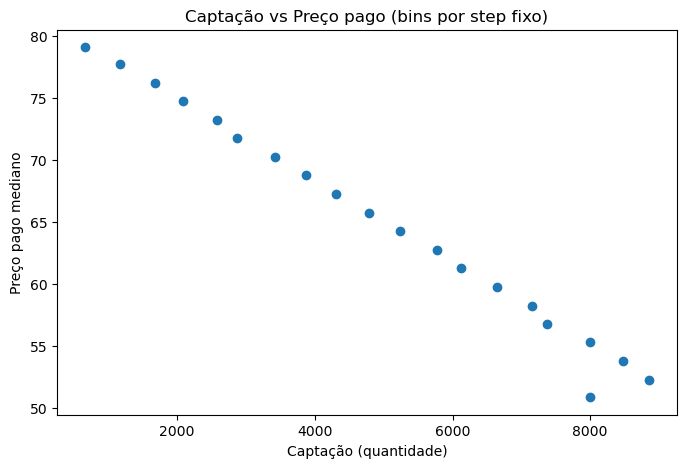

In [14]:
fig = plot_preco_vs_captacao(agg_preco)
fig

## Regressão linear para encontrar a curva de preço

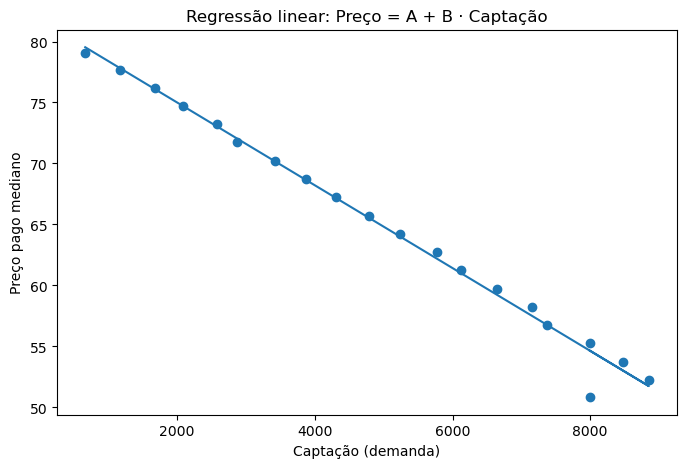

A = 81.785, B = -0.003, R² = 0.988


In [16]:
# ajusta a regressão linear entre preço e captação
fig_reg, A_hat, B_hat, r2 = regressao_linear_preco_captacao(agg_preco)
# exibe a figura com a reta ajustada
display(fig_reg)
# imprime os coeficientes estimados e a qualidade do ajuste
print(f"A = {A_hat:.3f}, B = {B_hat:.3f}, R² = {r2:.3f}")

## Agrega por intervalo de elasticidade (binning)

In [17]:
# agrega os dados em buckets por range de elasticidade para permitir variação real de captação
agg_elast = agregar_por_elasticidade(df, n_bins=20)

In [18]:
agg_elast

,bin_elasticidade,Elasticidade_media,ValorPago_media,Captacao,bucket_nome
0,"(1.441, 1.464]",1.453056,64.900916,8,bin_01
1,"(1.464, 1.486]",1.478215,62.435713,16,bin_02
2,"(1.486, 1.508]",1.501710,57.369956,87,bin_03
3,"(1.508, 1.529]",1.520733,58.037214,322,bin_04
4,"(1.529, 1.551]",1.542541,58.476646,980,bin_05
5,"(1.551, 1.573]",1.563879,57.812935,2511,bin_06
6,"(1.573, 1.595]",1.585490,58.759623,5281,bin_07
7,"(1.595, 1.617]",1.606894,58.869842,9451,bin_08
8,"(1.617, 1.638]",1.628139,58.831353,13637,bin_09
9,"(1.638, 1.66]",1.649415,59.189086,16624,bin_10


## Plot da curva de Laffer

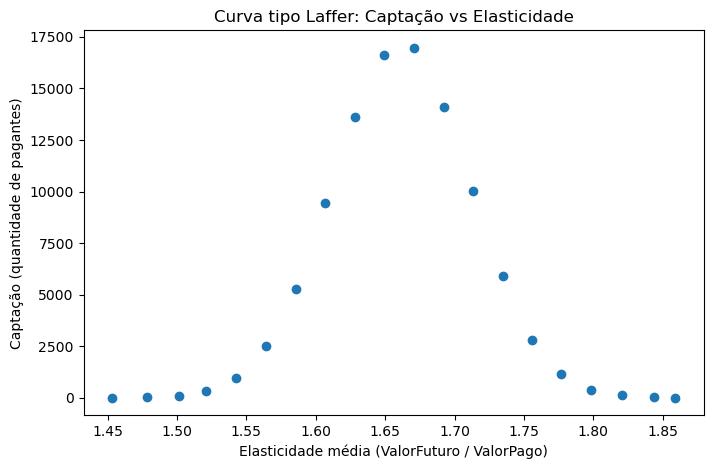

In [19]:
# plota o scatter Elasticidade média (x) versus Captação (y), retornando a figura fechada
fig_laffer = plot_laffer_scatter(agg_elast)
fig_laffer

## Fit polinomial da curva teórica de Laffer

a, b, c:
[-345897.18937671 1148296.45441305 -942746.6966025 ]
r2: 0.6173906723550409


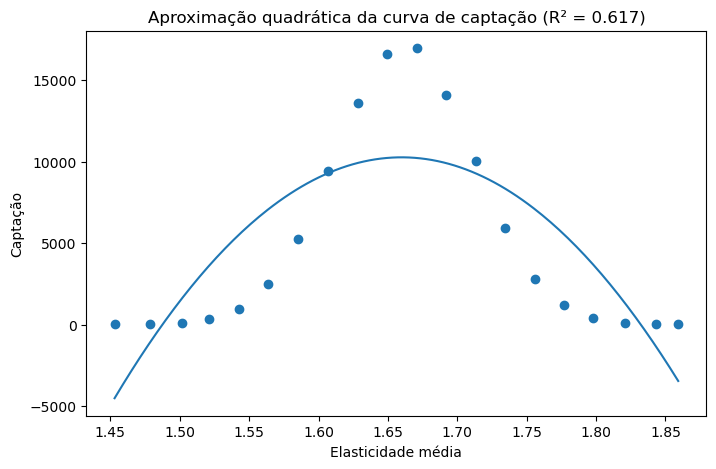

In [20]:
# ajusta a aproximação quadrática da curva de captação e retorna a figura e os coeficientes
fig_quad, coeficientes, r2 = plot_laffer_quadratico(agg_elast)
# imprime os coeficientes da parábola ajustada (a, b, c) para inspeção rápida
print("a, b, c:"); print(coeficientes) ; print('r2:', r2)
fig_quad